# Foreclosed Properties – Advanced Regression Modeling
**Predict Minimum Bid Price using Feature Engineering, Regularization & Ensemble Methods**

---
### Learning Objectives
By the end of this activity, students will be able to:
- Engineer features for regression tasks.
- Apply and compare multiple regression models including regularized and ensemble methods.
- Interpret model coefficients and assess feature importance.
- Evaluate model performance under different data conditions.
- Understand the trade-offs between bias, variance, and interpretability.

# **DATA COLLECTION**

## **Step 1:** Establish the Use Case

This notebook uses the **Foreclosed_Properties** dataset from UnionBank, which contains information about bank-foreclosed real estate properties.

**Objective:** Predict the **Minimum Bid Price** of a foreclosed property based on its physical and administrative attributes.

**Target variable:** `MINIMUM BID PRICE`

**Key features:** Lot area, floor area, location (region), property remarks, and title status.

## **Step 2:** Import Libraries

In [1]:
!pip install feature_engine shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, gaussian_kde

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from feature_engine.transformation import LogTransformer, BoxCoxTransformer
from feature_engine.outliers import Winsorizer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 8.7 MB/s eta 0:00:00
✅ All libraries imported successfully.


## **Step 3:** Load the Dataset

The dataset is loaded into the environment to allow inspection, preprocessing, and modeling. This step verifies that the file is readable and that the expected structure is present.

In [2]:
# Load dataset
df_raw = pd.read_csv('Foreclosed_Properties.csv', encoding='latin1')
print(f'Dataset shape: {df_raw.shape}')
df_raw.head()

Dataset shape: (594, 11)


,NO.,ADDRESS,LOT AREA (sqm),FLOOR AREA (sqm),CITY,PROVINCE,TYPE,MINIMUM BID PRICE,TCT NUMBER,STATUS OF TCT,REMARKS
0,1,Lot 1 Block 4 Roosevelt Drive Corner Mckinley ...,65,130.0,LAS PIÑAS,METRO MANILA,HOUSE AND LOT,"5,720,000.00",005-2015004314,TCT under the Bank,Unoccupied
1,2,"Lot 5, Aranda Compound, Barangay Talon Tres, L...",53,76.0,LAS PIÑAS,METRO MANILA,HOUSE AND LOT,"1,138,000.00",T-76287,TCT under the Bank,Occupied
2,3,"Lot 13-A-3 J. Facundo St., Vista Grande, Bf Re...",90,169.0,LAS PIÑAS,METRO MANILA,HOUSE AND LOT,"7,943,000.00",005-2011001272,TCT under the Bank,Unoccupied
3,4,"Building 15 Unit 15-B-2, Urci Townhomes, Brgy ...",NaN,69.4,LAS PIÑAS,METRO MANILA,TOWNHOUSE,"2,686,000.00",005-2020000361,TCT under the Bank,Unoccupied
4,5,"Lot 5 Block 5 Phantom St., Airmens Village, Br...",216,NaN,LAS PIÑAS,METRO MANILA,HOUSE AND LOT,"16,578,000.00",005-2015000231,TCT under the Bank,Unoccupied


## **Step 4:** Preview the Dataset

In [3]:
print(df_raw.shape)

(594, 11)


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NO.                594 non-null    int64  
 1   ADDRESS            594 non-null    object 
 2   LOT AREA (sqm)     592 non-null    object 
 3   FLOOR AREA (sqm)   591 non-null    float64
 4   CITY               594 non-null    object 
 5   PROVINCE           594 non-null    object 
 6   TYPE               594 non-null    object 
 7   MINIMUM BID PRICE  594 non-null    object 
 8   TCT NUMBER         594 non-null    object 
 9   STATUS OF TCT      594 non-null    object 
 10  REMARKS            594 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 51.2+ KB


# **DATA PRE-PROCESSING**

## **Step 5-A:** Remove Irrelevant Features

Columns that are too granular, non-informative, or redundant are dropped: `TCT NUMBER`, `ADDRESS`, `NO.`, `CITY`, `TYPE`.

In [5]:
df = df_raw.copy()
df.drop(columns=['TCT NUMBER', 'ADDRESS', 'NO.', 'CITY', 'TYPE'], inplace=True)
print('Remaining columns:', df.columns.tolist())
df.head()

Remaining columns: ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'PROVINCE', 'MINIMUM BID PRICE', 'STATUS OF TCT', 'REMARKS']


,LOT AREA (sqm),FLOOR AREA (sqm),PROVINCE,MINIMUM BID PRICE,STATUS OF TCT,REMARKS
0,65,130.0,METRO MANILA,"5,720,000.00",TCT under the Bank,Unoccupied
1,53,76.0,METRO MANILA,"1,138,000.00",TCT under the Bank,Occupied
2,90,169.0,METRO MANILA,"7,943,000.00",TCT under the Bank,Unoccupied
3,NaN,69.4,METRO MANILA,"2,686,000.00",TCT under the Bank,Unoccupied
4,216,NaN,METRO MANILA,"16,578,000.00",TCT under the Bank,Unoccupied


## **Step 5-B:** Categorical Feature Consolidation

Transform `PROVINCE` into a simplified `REGION` binary feature: **METRO MANILA** vs **NON-METRO MANILA**. This reduces high cardinality while retaining geographic signal.

In [6]:
df['REGION'] = df['PROVINCE'].apply(
    lambda x: 'METRO MANILA' if str(x).strip().upper() == 'METRO MANILA' else 'NON-METRO MANILA'
)
df.drop(columns=['PROVINCE'], inplace=True)
df.head()

,LOT AREA (sqm),FLOOR AREA (sqm),MINIMUM BID PRICE,STATUS OF TCT,REMARKS,REGION
0,65,130.0,"5,720,000.00",TCT under the Bank,Unoccupied,METRO MANILA
1,53,76.0,"1,138,000.00",TCT under the Bank,Occupied,METRO MANILA
2,90,169.0,"7,943,000.00",TCT under the Bank,Unoccupied,METRO MANILA
3,NaN,69.4,"2,686,000.00",TCT under the Bank,Unoccupied,METRO MANILA
4,216,NaN,"16,578,000.00",TCT under the Bank,Unoccupied,METRO MANILA


## **Step 5-C:** Convert Data Types

Clean and convert `LOT AREA (sqm)`, `MINIMUM BID PRICE`, and `FLOOR AREA (sqm)` to numeric floats. Values may contain commas or colons that need to be stripped.

In [7]:
for col in ['LOT AREA (sqm)', 'MINIMUM BID PRICE']:
    df[col] = (df[col].astype(str)
               .str.replace(',', '', regex=False)
               .str.replace(':', '.', regex=False))
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['FLOOR AREA (sqm)'] = pd.to_numeric(df['FLOOR AREA (sqm)'], errors='coerce')

print('Data types after conversion:')
print(df.dtypes)

Data types after conversion:
LOT AREA (sqm)       float64
FLOOR AREA (sqm)     float64
MINIMUM BID PRICE    float64
STATUS OF TCT         object
REMARKS               object
REGION                object
dtype: object


## **Step 5-D**: Descriptive Statistics for Continuous Variables

Summarize the central tendency, spread, and range of numerical features.

In [8]:
df.describe()

,LOT AREA (sqm),FLOOR AREA (sqm),MINIMUM BID PRICE
count,592.000000,591.000000,5.940000e+02
mean,183.861199,35.076396,2.836867e+06
std,1451.869152,65.612799,4.972103e+06
min,0.000000,0.000000,4.000000e+04
25%,2.500000,0.000000,4.600000e+04
50%,2.500000,18.000000,1.639500e+06
75%,72.000000,48.000000,4.180750e+06
max,24309.390000,692.500000,8.500000e+07


## **Step 5-E:** Define Continuous and Categorical Variables

Separating variables by type helps guide the appropriate preprocessing and analysis for each.

In [9]:
continuous_variable = ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'MINIMUM BID PRICE']
categorical_variable = ['REMARKS', 'REGION', 'STATUS OF TCT']

print('Continuous variables:', continuous_variable)
print('Categorical variables:', categorical_variable)

Continuous variables: ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'MINIMUM BID PRICE']
Categorical variables: ['REMARKS', 'REGION', 'STATUS OF TCT']


## **Step 6:** Handle Missing Values

Check for missing values and fill gaps using **median imputation** — appropriate for skewed distributions since the median is robust to outliers.

In [10]:
print('Missing values before imputation:')
print(df.isnull().sum())

for col in ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'MINIMUM BID PRICE']:
    df[col].fillna(df[col].median(), inplace=True)

print('\nMissing values after imputation:')
print(df.isnull().sum())
df.head()

Missing values before imputation:
LOT AREA (sqm)       2
FLOOR AREA (sqm)     3
MINIMUM BID PRICE    0
STATUS OF TCT        0
REMARKS              0
REGION               0
dtype: int64

Missing values after imputation:
LOT AREA (sqm)       0
FLOOR AREA (sqm)     0
MINIMUM BID PRICE    0
STATUS OF TCT        0
REMARKS              0
REGION               0
dtype: int64


,LOT AREA (sqm),FLOOR AREA (sqm),MINIMUM BID PRICE,STATUS OF TCT,REMARKS,REGION
0,65.0,130.0,5720000.0,TCT under the Bank,Unoccupied,METRO MANILA
1,53.0,76.0,1138000.0,TCT under the Bank,Occupied,METRO MANILA
2,90.0,169.0,7943000.0,TCT under the Bank,Unoccupied,METRO MANILA
3,2.5,69.4,2686000.0,TCT under the Bank,Unoccupied,METRO MANILA
4,216.0,18.0,16578000.0,TCT under the Bank,Unoccupied,METRO MANILA


## **Step 7:** Visualize Missing Data Distribution

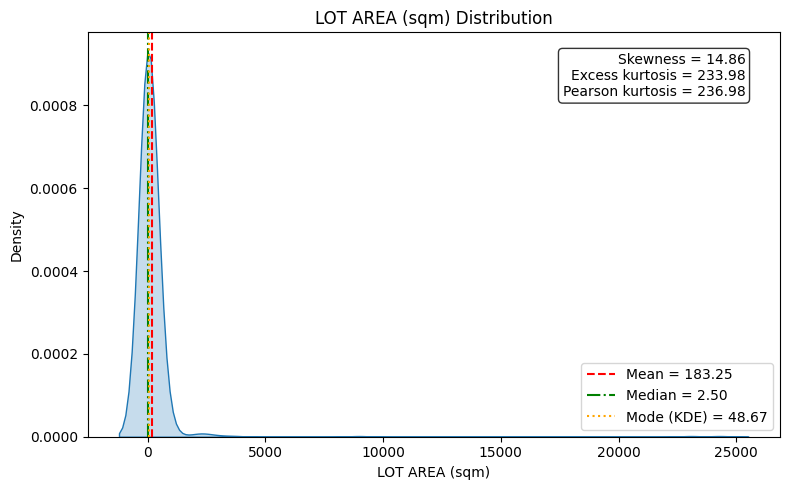

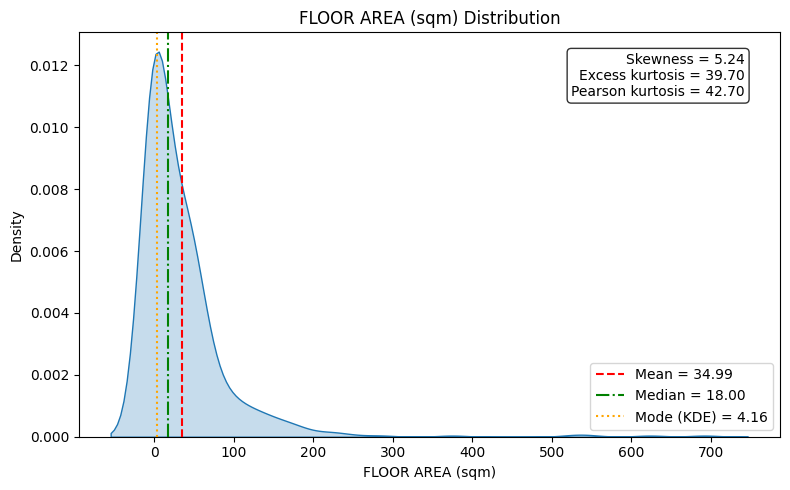

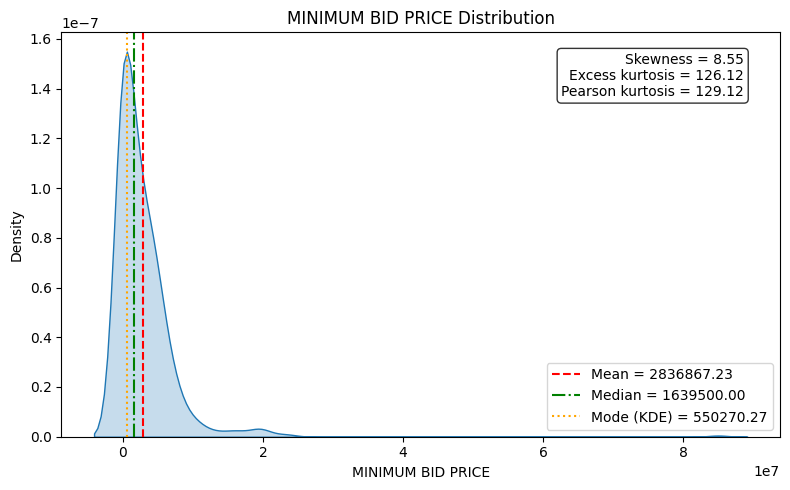

In [11]:
for col in continuous_variable:
    data = df[col].dropna()

    plt.figure(figsize=(8, 5))
    sns.kdeplot(data, fill=True)

    mean   = data.mean()
    median = data.median()
    kde    = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    mode   = x_vals[np.argmax(kde(x_vals))]

    skewness     = skew(data)
    excess_kurt  = kurtosis(data)
    pearson_kurt = excess_kurt + 3

    plt.axvline(mean,   color='red',    linestyle='--', label=f'Mean = {mean:.2f}')
    plt.axvline(median, color='green',  linestyle='-.', label=f'Median = {median:.2f}')
    plt.axvline(mode,   color='orange', linestyle=':',  label=f'Mode (KDE) = {mode:.2f}')

    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Density')

    stats_text = (f'Skewness = {skewness:.2f}\nExcess kurtosis = {excess_kurt:.2f}\nPearson kurtosis = {pearson_kurt:.2f}')
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.legend()
    plt.tight_layout()
    plt.show()

## **Step 8:** Encode Categorical Variables

Convert `REMARKS`, `REGION`, and `STATUS OF TCT` into dummy/binary variables using one-hot encoding. `drop_first=True` avoids multicollinearity.

In [12]:
df_encoded = pd.get_dummies(df, columns=['REMARKS', 'REGION', 'STATUS OF TCT'], drop_first=True)
print('Encoded columns:', df_encoded.columns.tolist())
df_encoded.head()

Encoded columns: ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'MINIMUM BID PRICE', 'REMARKS_Unoccupied', 'REGION_NON-METRO MANILA', 'STATUS OF TCT_TCT under the Bank']


,LOT AREA (sqm),FLOOR AREA (sqm),MINIMUM BID PRICE,REMARKS_Unoccupied,REGION_NON-METRO MANILA,STATUS OF TCT_TCT under the Bank
0,65.0,130.0,5720000.0,True,False,True
1,53.0,76.0,1138000.0,False,False,True
2,90.0,169.0,7943000.0,True,False,True
3,2.5,69.4,2686000.0,True,False,True
4,216.0,18.0,16578000.0,True,False,True


### Visualize Categorical Feature Distributions

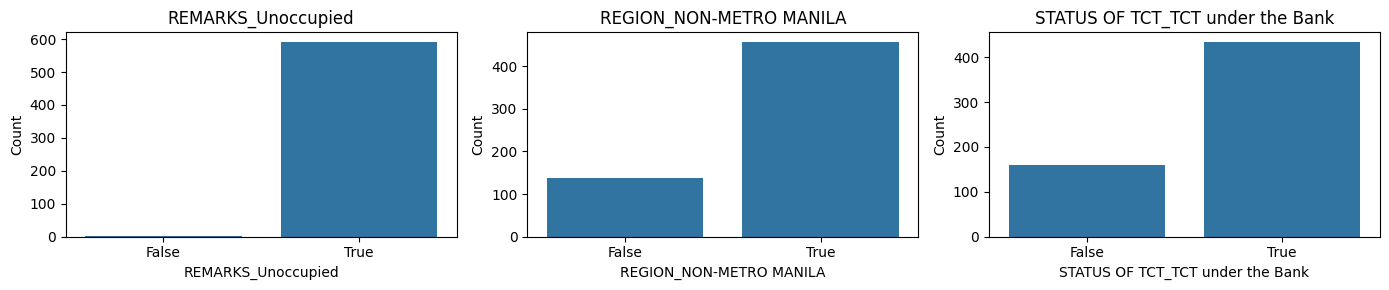

In [13]:
bool_cols = [col for col in df_encoded.columns
             if col.startswith(('REMARKS', 'REGION', 'STATUS OF TCT'))]

plt.figure(figsize=(14, 3))
for i, col in enumerate(bool_cols, 1):
    plt.subplot(1, len(bool_cols), i)
    sns.countplot(x=df_encoded[col])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## **Step 9:** Category Counts for Categorical Variables

Understanding the distribution of categories helps detect class imbalance and inform encoding decisions.

In [14]:
for col in ['REMARKS', 'REGION', 'STATUS OF TCT']:
    print(f'\nCategory counts for {col}:')
    print(df[col].value_counts())


Category counts for REMARKS:
REMARKS
Unoccupied    591
Occupied        3
Name: count, dtype: int64

Category counts for REGION:
REGION
NON-METRO MANILA    457
METRO MANILA        137
Name: count, dtype: int64

Category counts for STATUS OF TCT:
STATUS OF TCT
TCT under the Bank         434
For Title Consolidation    160
Name: count, dtype: int64


## **Step 10-A:** Detect Outliers Using IQR



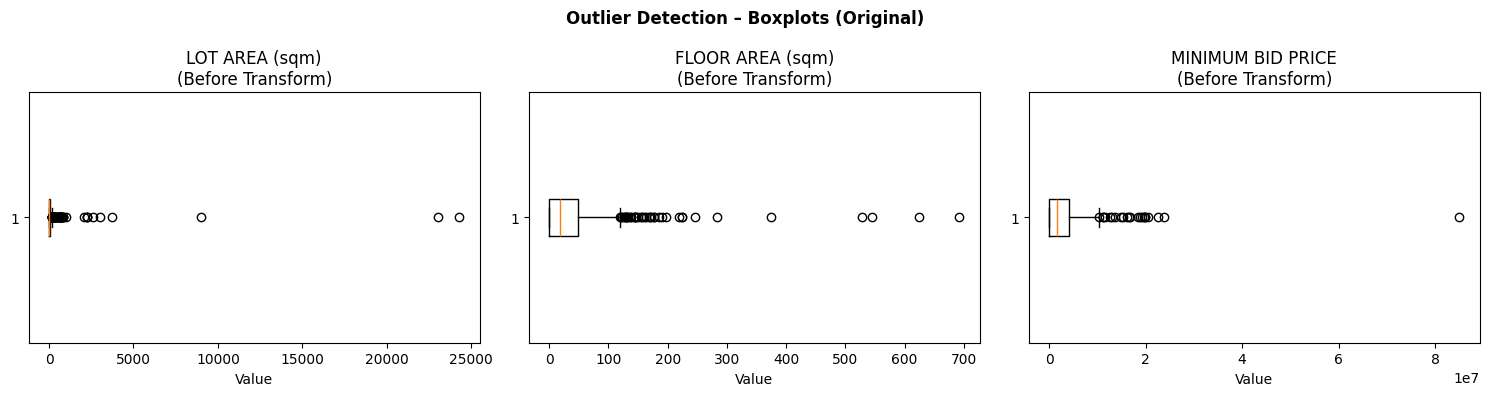

IQR for numeric columns:
LOT AREA (sqm)            69.0
FLOOR AREA (sqm)          47.9
MINIMUM BID PRICE    4134750.0
dtype: float64


In [15]:
num_cols_cont = ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'MINIMUM BID PRICE']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, num_cols_cont):
    ax.boxplot(df_encoded[col].dropna(), vert=False)
    ax.set_title(f'{col}\n(Before Transform)')
    ax.set_xlabel('Value')
plt.suptitle('Outlier Detection – Boxplots (Original)', fontweight='bold')
plt.tight_layout()
plt.show()

num_cols_all = df_encoded.select_dtypes(include=['int64', 'float64']).columns
Q1  = df_encoded[num_cols_all].quantile(0.25)
Q3  = df_encoded[num_cols_all].quantile(0.75)
IQR = Q3 - Q1
print('IQR for numeric columns:')
print(IQR)

## **Step 10-B:** Outlier Detection – RobustScaler

RobustScaler uses the median and IQR to scale features, making it insensitive to outliers.

In [16]:
num_cols_all = df_encoded.select_dtypes(include=['int64', 'float64']).columns
robust_scaler  = RobustScaler()
scaled_robust  = robust_scaler.fit_transform(df_encoded[num_cols_all])
scaled_df_robust = pd.DataFrame(scaled_robust, columns=num_cols_all)
print('Potential outliers (|RobustScaled| > 1.5):')
print((np.abs(scaled_df_robust) > 1.5).sum())

Potential outliers (|RobustScaled| > 1.5):
LOT AREA (sqm)       93
FLOOR AREA (sqm)     60
MINIMUM BID PRICE    40
dtype: int64


## **Step 10-C:** Outlier Detection – Winsorization

Winsorization caps extreme values at a specified percentile, reducing the impact of outliers without removing data points.

In [17]:
winsor = Winsorizer()
scaled_winsor    = winsor.fit_transform(df_encoded[num_cols_all])
scaled_df_winsor = pd.DataFrame(scaled_winsor, columns=num_cols_all)
print('Potential outliers after Winsorization (|value| > 1.5):')
print((np.abs(scaled_df_winsor) > 1.5).sum())

Potential outliers after Winsorization (|value| > 1.5):
LOT AREA (sqm)       465
FLOOR AREA (sqm)     301
MINIMUM BID PRICE    594
dtype: int64


## **Step 10-D:** Outlier Detection – Log Transformer

Log transformation compresses the right tail of skewed distributions, reducing the relative magnitude of outliers.

In [18]:
df_shifted  = df_encoded[num_cols_all] + 1
log_trans   = LogTransformer()
scaled_log  = log_trans.fit_transform(df_shifted)
scaled_df_log = pd.DataFrame(scaled_log, columns=num_cols_all)
print('Potential outliers after Log Transform (|value| > 1.5):')
print((np.abs(scaled_df_log) > 1.5).sum())

Potential outliers after Log Transform (|value| > 1.5):
LOT AREA (sqm)       213
FLOOR AREA (sqm)     301
MINIMUM BID PRICE    594
dtype: int64


## **Step 10-E:** Outlier Detection – Box-Cox Transformer

Box-Cox is a power transformation that finds the optimal lambda to normalise the distribution. Requires strictly positive values.

In [19]:
df_shifted_bc = df_encoded[num_cols_all] + 1
boxcox_trans  = BoxCoxTransformer()
scaled_boxcox = boxcox_trans.fit_transform(df_shifted_bc)
scaled_df_boxcox = pd.DataFrame(scaled_boxcox, columns=num_cols_all)
print('Potential outliers after Box-Cox Transform (|value| > 1.5):')
print((np.abs(scaled_df_boxcox) > 1.5).sum())

Potential outliers after Box-Cox Transform (|value| > 1.5):
LOT AREA (sqm)       213
FLOOR AREA (sqm)     301
MINIMUM BID PRICE    594
dtype: int64


## **Step 10-F:** Outlier Detection – StandardScaler

StandardScaler normalises to zero mean and unit variance.

In [20]:
std_scaler    = StandardScaler()
scaled_std    = std_scaler.fit_transform(df_encoded[num_cols_all])
scaled_df_std = pd.DataFrame(scaled_std, columns=num_cols_all)
print('Potential outliers after StandardScaler (|value| > 1.5):')
print((np.abs(scaled_df_std) > 1.5).sum())

Potential outliers after StandardScaler (|value| > 1.5):
LOT AREA (sqm)        6
FLOOR AREA (sqm)     29
MINIMUM BID PRICE    24
dtype: int64


## **Step 11:** Compare Outlier Detection Methods (Visual)

Side-by-side boxplots comparing how each method affects the distribution of the three key features.

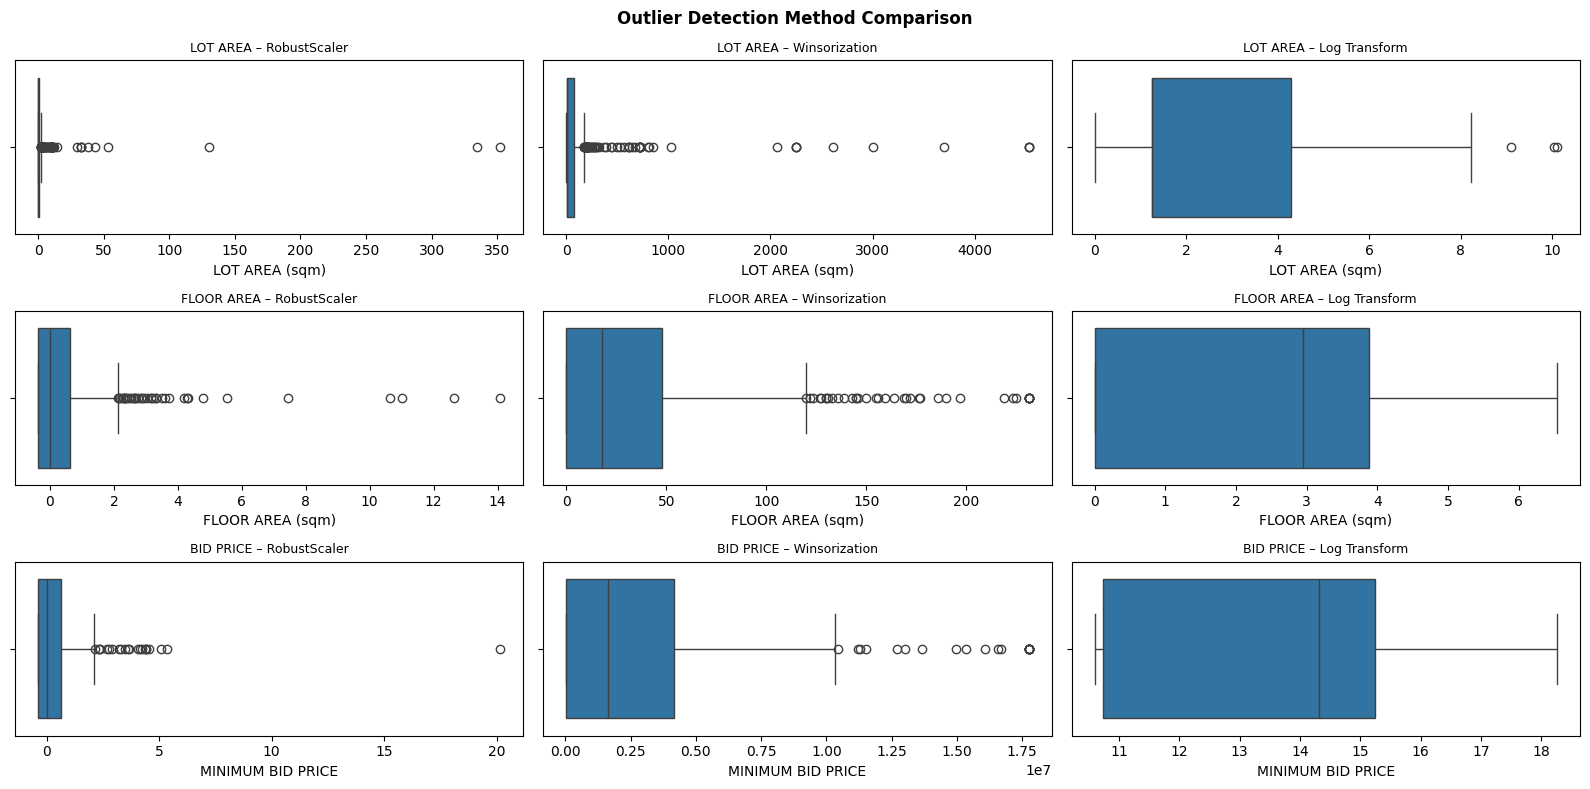

In [21]:
columns_to_plot = {
    'LOT AREA – RobustScaler'    : scaled_df_robust['LOT AREA (sqm)'],
    'LOT AREA – Winsorization'   : scaled_df_winsor['LOT AREA (sqm)'],
    'LOT AREA – Log Transform'   : scaled_df_log['LOT AREA (sqm)'],
    'FLOOR AREA – RobustScaler'  : scaled_df_robust['FLOOR AREA (sqm)'],
    'FLOOR AREA – Winsorization' : scaled_df_winsor['FLOOR AREA (sqm)'],
    'FLOOR AREA – Log Transform' : scaled_df_log['FLOOR AREA (sqm)'],
    'BID PRICE – RobustScaler'   : scaled_df_robust['MINIMUM BID PRICE'],
    'BID PRICE – Winsorization'  : scaled_df_winsor['MINIMUM BID PRICE'],
    'BID PRICE – Log Transform'  : scaled_df_log['MINIMUM BID PRICE'],
}

plt.figure(figsize=(16, 8))
for i, (name, data) in enumerate(columns_to_plot.items(), 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data)
    plt.title(name, fontsize=9)
plt.suptitle('Outlier Detection Method Comparison', fontweight='bold')
plt.tight_layout()
plt.show()

## **Step 12:** Handle Outliers – Apply Log1p Transformation

Based on the comparison above, **Log Transformation** is selected as the best method. It effectively reduces skewness and compresses outliers while preserving all data points.


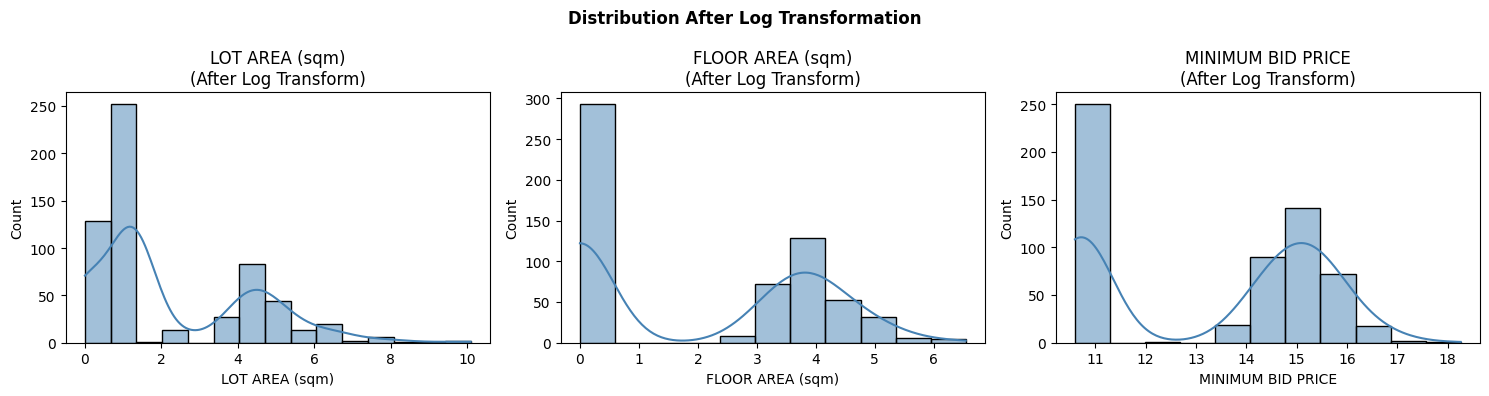

Skewness after transformation:
  LOT AREA (sqm): 0.872
  FLOOR AREA (sqm): 0.147
  MINIMUM BID PRICE: -0.149


In [22]:
log_cols = ['LOT AREA (sqm)', 'FLOOR AREA (sqm)', 'MINIMUM BID PRICE']
for col in log_cols:
    df_encoded[col] = np.log1p(df_encoded[col])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, log_cols):
    sns.histplot(df_encoded[col], kde=True, ax=ax, color='steelblue')
    ax.set_title(f'{col}\n(After Log Transform)')
plt.suptitle('Distribution After Log Transformation', fontweight='bold')
plt.tight_layout()
plt.show()

print('Skewness after transformation:')
for col in log_cols:
    print(f'  {col}: {df_encoded[col].skew():.3f}')

## **Step 13:** Multicollinearity Check – Correlation Matrix

A heatmap of feature correlations reveals redundant features. High correlation (|r| > 0.8) between predictors indicates multicollinearity.

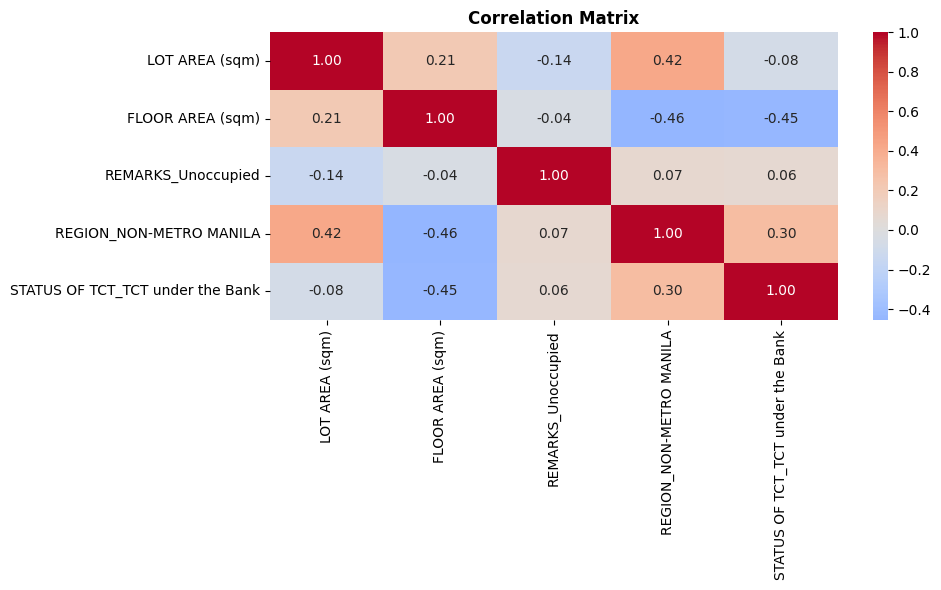

In [23]:
X_corr = df_encoded.drop(columns=['MINIMUM BID PRICE'])
correlation = X_corr.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

## **Step 14-A:** Variance Inflation Factor (VIF)

VIF quantifies how much the variance of a regression coefficient is inflated due to multicollinearity. - **VIF < 5**: Acceptable
- **VIF 5–10**: Moderate concern
- **VIF > 10**: High multicollinearity — consider removing the feature

                         Feature       VIF
                  LOT AREA (sqm)  3.566647
                FLOOR AREA (sqm)  3.679057
              REMARKS_Unoccupied 13.091036
         REGION_NON-METRO MANILA  8.885524
STATUS OF TCT_TCT under the Bank  4.683731


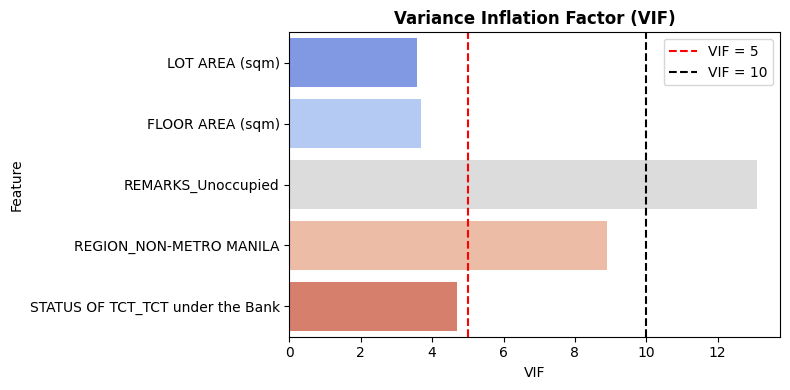

In [24]:
df_vif = df_encoded.copy()
X_vif  = df_vif.drop(columns=['MINIMUM BID PRICE']).astype(float)
y_vif  = df_vif['MINIMUM BID PRICE']

vif_data = pd.DataFrame({
    'Feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_data.to_string(index=False))

plt.figure(figsize=(8, 4))
sns.barplot(x='VIF', y='Feature', data=vif_data, palette='coolwarm')
plt.axvline(5,  color='red',   linestyle='--', label='VIF = 5')
plt.axvline(10, color='black', linestyle='--', label='VIF = 10')
plt.title('Variance Inflation Factor (VIF)', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## **Step 14-B:** Pre-model Feature Importance – ExtraTreesRegressor

ExtraTreesRegressor provides a quick feature importance ranking before formal modelling, helping identify which features carry the most predictive signal.

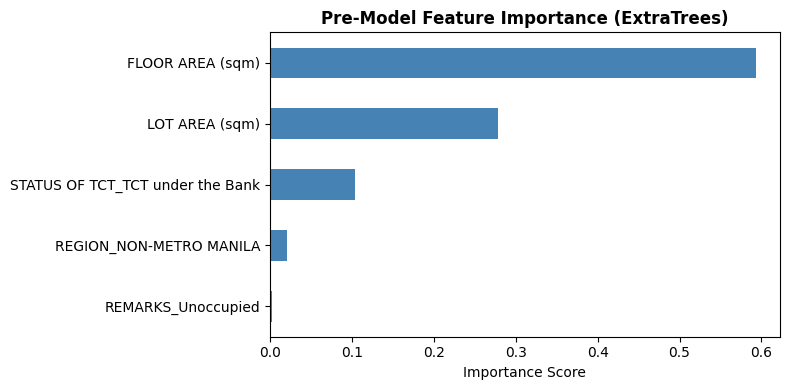

In [25]:
X_etr = df_vif.drop(columns=['MINIMUM BID PRICE']).astype(float)
y_etr = df_vif['MINIMUM BID PRICE']

etr_model = ExtraTreesRegressor(random_state=42)
etr_model.fit(X_etr, y_etr)

data_importances = pd.Series(etr_model.feature_importances_, index=X_etr.columns)
data_importances.nlargest(9).sort_values().plot(kind='barh', color='steelblue', figsize=(8, 4))
plt.title('Pre-Model Feature Importance (ExtraTrees)', fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## **Step 15: OLS** Regression (Pre-Outlier Removal Baseline)

An OLS regression summary provides a statistical baseline: p-values, R², F-statistic, and coefficient significance. This helps identify which features are statistically significant before applying ML models.

In [26]:
X_ols = df_encoded.drop(columns=['MINIMUM BID PRICE']).astype(float)
y_ols = df_encoded['MINIMUM BID PRICE']
X_ols_const = sm.add_constant(X_ols)

ols_model = sm.OLS(y_ols, X_ols_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      MINIMUM BID PRICE   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     780.0
Date:                Wed, 25 Feb 2026   Prob (F-statistic):          9.56e-257
Time:                        17:28:11   Log-Likelihood:                -716.81
No. Observations:                 594   AIC:                             1446.
Df Residuals:                     588   BIC:                             1472.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

# **FEATURE ENGINEERING**

## **Step 16:** Engineer New Features

Create **5 engineered features** based on domain knowledge and correlation analysis:

| Feature | Rationale |
|---|---|
| `PRICE_PER_SQM` | Standard real estate valuation metric – normalises bid price by lot size |
| `TOTAL_AREA` | Combines lot + floor area to capture overall property size |
| `FLOOR_TO_LOT_RATIO` | Measures land use intensity; higher ratio → denser development |
| `LOG_LOT_x_FLOOR` | Interaction term capturing multiplicative effect of both area features |
| `IS_LARGE_PROPERTY` | Binary flag for top-quartile properties; captures premium property segment |

In [27]:
df_feat = df_encoded.copy()

lot_area_orig = np.expm1(df_feat['LOT AREA (sqm)'])
price_orig    = np.expm1(df_feat['MINIMUM BID PRICE'])
floor_orig    = np.expm1(df_feat['FLOOR AREA (sqm)'])

# Feature 1: Price per sqm
df_feat['PRICE_PER_SQM']      = np.log1p(price_orig / (lot_area_orig + 1))
# Feature 2: Total area
df_feat['TOTAL_AREA']          = df_feat['LOT AREA (sqm)'] + df_feat['FLOOR AREA (sqm)']
# Feature 3: Floor-to-lot ratio
df_feat['FLOOR_TO_LOT_RATIO']  = np.log1p(floor_orig / (lot_area_orig + 1))
# Feature 4: Interaction term
df_feat['LOG_LOT_x_FLOOR']     = df_feat['LOT AREA (sqm)'] * df_feat['FLOOR AREA (sqm)']
# Feature 5: Large property flag
threshold = df_feat['LOT AREA (sqm)'].quantile(0.75)
df_feat['IS_LARGE_PROPERTY']   = (df_feat['LOT AREA (sqm)'] >= threshold).astype(int)

print(f'Total features after engineering: {df_feat.shape[1]}')
df_feat.head()

Total features after engineering: 11


,LOT AREA (sqm),FLOOR AREA (sqm),MINIMUM BID PRICE,REMARKS_Unoccupied,REGION_NON-METRO MANILA,STATUS OF TCT_TCT under the Bank,PRICE_PER_SQM,TOTAL_AREA,FLOOR_TO_LOT_RATIO,LOG_LOT_x_FLOOR,IS_LARGE_PROPERTY
0,4.189655,4.875197,15.559480,True,False,True,11.369836,9.064852,1.088460,20.425394,0
1,3.988984,4.343805,13.944784,False,False,True,9.955846,8.332789,0.878550,17.327371,0
2,4.510860,5.135798,15.887802,True,False,True,11.376954,9.646658,1.049822,23.166865,1
3,1.252763,4.254193,14.803564,True,False,True,13.550802,5.506956,3.036326,5.329496,0
4,5.379897,2.944439,16.623587,True,False,True,11.243703,8.324336,0.079688,15.840779,1


## **Step 17:** Correlation of Engineered Features vs. Target

A correlation heatmap confirms which engineered features are most predictive of the target variable.

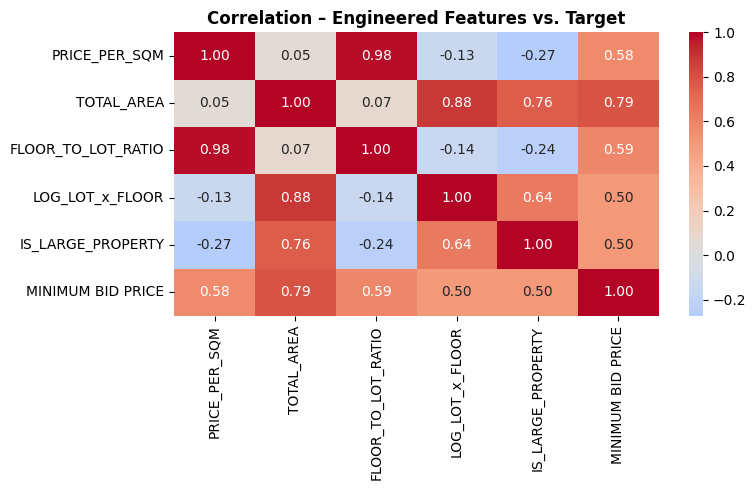

In [28]:
eng_features = ['PRICE_PER_SQM', 'TOTAL_AREA', 'FLOOR_TO_LOT_RATIO',
                'LOG_LOT_x_FLOOR', 'IS_LARGE_PROPERTY', 'MINIMUM BID PRICE']

corr_matrix = df_feat[eng_features].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation – Engineered Features vs. Target', fontweight='bold')
plt.tight_layout()
plt.show()

# **BUILDING THE MODEL**

## **Step 18:** Train/Test Split & Feature Scaling

The dataset is split **70% train / 15% validation / 15% test** to enable proper evaluation and detect overfitting. StandardScaler is applied to ensure regularized linear models are not biased by feature magnitudes.

In [29]:
X = df_feat.drop(columns=['MINIMUM BID PRICE']).astype(float)
y = df_feat['MINIMUM BID PRICE'].astype(float)

# Remove any NaN/Inf
mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X, y = X[mask], y[mask]

# 70 / 15 / 15 split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
val_size = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

# Scale
scaler         = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(f'Training   : {X_train.shape[0]} rows')
print(f'Validation : {X_val.shape[0]} rows')
print(f'Test       : {X_test.shape[0]} rows')
print(f'Features   : {X_train.shape[1]}')

Training   : 415 rows
Validation : 89 rows
Test       : 90 rows
Features   : 10


## **Step 19:** Model Implementation

Six regression models are implemented and compared:
1. **Linear Regression** – baseline
2. **Ridge Regression** – L2 regularization
3. **Lasso Regression** – L1 regularization (feature selection)
4. **Elastic Net** – L1 + L2 combined
5. **Random Forest** – ensemble tree method
6. **Gradient Boosting** – sequential boosting ensemble

In [30]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae  = mean_absolute_error(y_te, y_pred)
    r2   = r2_score(y_te, y_pred)
    cv   = cross_val_score(model, X_tr, y_tr, cv=5, scoring='r2').mean()
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'R² Score': r2,
            'CV R² (5-fold)': cv, 'predictions': y_pred, 'fitted_model': model}

results = {}

### **Step 19-A:** Linear Regression

In [31]:
lr = LinearRegression()
results['Linear Regression'] = evaluate_model(
    'Linear Regression', lr, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Linear Regression → R²: {results['Linear Regression']['R² Score']:.4f} | RMSE: {results['Linear Regression']['RMSE']:.4f}")

Linear Regression → R²: 1.0000 | RMSE: 0.0001


### **Step 19-B:** Ridge Regression

In [32]:
ridge = Ridge(alpha=1.0)
results['Ridge'] = evaluate_model('Ridge', ridge, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Ridge → R²: {results['Ridge']['R² Score']:.4f} | RMSE: {results['Ridge']['RMSE']:.4f}")

Ridge → R²: 0.9997 | RMSE: 0.0390


### **Step 19-C:** Lasso Regression

In [33]:
lasso = Lasso(alpha=0.01, max_iter=5000)
results['Lasso'] = evaluate_model('Lasso', lasso, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Lasso → R²: {results['Lasso']['R² Score']:.4f} | RMSE: {results['Lasso']['RMSE']:.4f}")

Lasso → R²: 0.9998 | RMSE: 0.0303


### **Step 19-D:** Elastic Net

In [34]:
enet = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000)
results['ElasticNet'] = evaluate_model('ElasticNet', enet, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"ElasticNet → R²: {results['ElasticNet']['R² Score']:.4f} | RMSE: {results['ElasticNet']['RMSE']:.4f}")

ElasticNet → R²: 0.9984 | RMSE: 0.0886


### **Step 19-E:** Random Forest Regressor

In [35]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
results['Random Forest'] = evaluate_model('Random Forest', rf, X_train, y_train, X_test, y_test)
print(f"Random Forest → R²: {results['Random Forest']['R² Score']:.4f} | RMSE: {results['Random Forest']['RMSE']:.4f}")

Random Forest → R²: 0.9845 | RMSE: 0.2783


### **Step 19-F:** Gradient Boosting Regressor

In [36]:
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05,
                                subsample=0.8, random_state=42)
results['Gradient Boosting'] = evaluate_model('Gradient Boosting', gb, X_train, y_train, X_test, y_test)
print(f"Gradient Boosting → R²: {results['Gradient Boosting']['R² Score']:.4f} | RMSE: {results['Gradient Boosting']['RMSE']:.4f}")

Gradient Boosting → R²: 0.9889 | RMSE: 0.2356


# **HYPERPARAMETER TUNING**

## **Step 20:** GridSearchCV Tuning

GridSearchCV performs exhaustive search over a parameter grid with 5-fold cross-validation to identify the optimal hyperparameters for each model.

### **Step 20-A:** Tune Ridge (alpha)

In [37]:
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 500.0]}
ridge_gs = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_gs.fit(X_train_scaled, y_train)

best_ridge = ridge_gs.best_estimator_
results['Ridge (Tuned)'] = evaluate_model(
    'Ridge (Tuned)', best_ridge, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Best alpha: {ridge_gs.best_params_}")
print(f"Tuned Ridge → R²: {results['Ridge (Tuned)']['R² Score']:.4f} | RMSE: {results['Ridge (Tuned)']['RMSE']:.4f}")

Best alpha: {'alpha': 0.01}
Tuned Ridge → R²: 1.0000 | RMSE: 0.0004


### **Step 20-B:** Tune Lasso (alpha)

In [38]:
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
lasso_gs = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='r2', n_jobs=-1)
lasso_gs.fit(X_train_scaled, y_train)

best_lasso = lasso_gs.best_estimator_
results['Lasso (Tuned)'] = evaluate_model(
    'Lasso (Tuned)', best_lasso, X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Best alpha: {lasso_gs.best_params_}")
print(f"Tuned Lasso → R²: {results['Lasso (Tuned)']['R² Score']:.4f} | RMSE: {results['Lasso (Tuned)']['RMSE']:.4f}")

Best alpha: {'alpha': 0.0001}
Tuned Lasso → R²: 1.0000 | RMSE: 0.0004


### **Step 20-C:** Tune Random Forest (depth, estimators)

In [39]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5]
}
rf_gs = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                     rf_params, cv=5, scoring='r2', n_jobs=-1)
rf_gs.fit(X_train, y_train)

best_rf = rf_gs.best_estimator_
results['Random Forest (Tuned)'] = evaluate_model(
    'Random Forest (Tuned)', best_rf, X_train, y_train, X_test, y_test)
print(f"Best params: {rf_gs.best_params_}")
print(f"Tuned RF → R²: {results['Random Forest (Tuned)']['R² Score']:.4f} | RMSE: {results['Random Forest (Tuned)']['RMSE']:.4f}")

Best params: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RF → R²: 0.9847 | RMSE: 0.2768


### **Step 20-D:** Tune Gradient Boosting (depth, learning_rate)

In [40]:
gb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
gb_gs = GridSearchCV(GradientBoostingRegressor(subsample=0.8, random_state=42),
                     gb_params, cv=5, scoring='r2', n_jobs=-1)
gb_gs.fit(X_train, y_train)

best_gb = gb_gs.best_estimator_
results['Gradient Boosting (Tuned)'] = evaluate_model(
    'Gradient Boosting (Tuned)', best_gb, X_train, y_train, X_test, y_test)
print(f"Best params: {gb_gs.best_params_}")
print(f"Tuned GB → R²: {results['Gradient Boosting (Tuned)']['R² Score']:.4f} | RMSE: {results['Gradient Boosting (Tuned)']['RMSE']:.4f}")

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Tuned GB → R²: 0.9902 | RMSE: 0.2211


# **MODEL EVALUATION & COMPARISON**

## Summary Table

Compare all models by RMSE, MAE, R² Score, and 5-fold cross-validated R².

In [41]:
summary_keys = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet',
                'Random Forest', 'Gradient Boosting',
                'Ridge (Tuned)', 'Lasso (Tuned)',
                'Random Forest (Tuned)', 'Gradient Boosting (Tuned)']

summary = pd.DataFrame([
    {'Model': k, 'RMSE': results[k]['RMSE'], 'MAE': results[k]['MAE'],
     'R² Score': results[k]['R² Score'], 'CV R² (5-fold)': results[k]['CV R² (5-fold)']}
    for k in summary_keys
]).sort_values('R² Score', ascending=False).reset_index(drop=True)

summary.style \
    .background_gradient(subset=['R² Score'], cmap='Greens') \
    .background_gradient(subset=['RMSE', 'MAE'], cmap='Reds_r') \
    .format({'RMSE': '{:.4f}', 'MAE': '{:.4f}', 'R² Score': '{:.4f}', 'CV R² (5-fold)': '{:.4f}'})

,Model,RMSE,MAE,R² Score,CV R² (5-fold)
0,Linear Regression,0.0001,0.0000,1.0000,1.0000
1,Ridge (Tuned),0.0004,0.0003,1.0000,1.0000
2,Lasso (Tuned),0.0004,0.0002,1.0000,1.0000
3,Lasso,0.0303,0.0237,0.9998,0.9998
4,Ridge,0.0390,0.0259,0.9997,0.9995
5,ElasticNet,0.0886,0.0620,0.9984,0.9983
6,Gradient Boosting (Tuned),0.2211,0.0758,0.9902,0.9917
7,Gradient Boosting,0.2356,0.0673,0.9889,0.9914
8,Random Forest (Tuned),0.2768,0.0879,0.9847,0.9894
9,Random Forest,0.2783,0.0895,0.9845,0.9890


## **Step 22:** Train / Validation / Test Metrics per Model

Evaluating on all three splits reveals whether a model is overfitting (train >> val/test) or generalising well.

In [42]:
def compute_metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

split_rows = []
for name, model_key, X_tr, X_va, X_te in [
    ('Linear Regression',         'Linear Regression',         X_train_scaled, X_val_scaled, X_test_scaled),
    ('Ridge (Tuned)',              'Ridge (Tuned)',              X_train_scaled, X_val_scaled, X_test_scaled),
    ('Lasso (Tuned)',              'Lasso (Tuned)',              X_train_scaled, X_val_scaled, X_test_scaled),
    ('Random Forest (Tuned)',      'Random Forest (Tuned)',      X_train,        X_val,        X_test),
    ('Gradient Boosting (Tuned)',  'Gradient Boosting (Tuned)',  X_train,        X_val,        X_test),
]:
    model_obj = results[model_key]['fitted_model']
    for split_name, X_sp, y_sp in [('Train', X_tr, y_train), ('Val', X_va, y_val), ('Test', X_te, y_test)]:
        r2, rmse, mae = compute_metrics(y_sp, model_obj.predict(X_sp))
        split_rows.append({'Model': name, 'Split': split_name, 'R²': r2, 'RMSE': rmse, 'MAE': mae})

split_df = pd.DataFrame(split_rows)
print(split_df.to_string(index=False))

                    Model Split       R²     RMSE      MAE
        Linear Regression Train 1.000000 0.000137 0.000059
        Linear Regression   Val 1.000000 0.000116 0.000074
        Linear Regression  Test 1.000000 0.000076 0.000049
            Ridge (Tuned) Train 1.000000 0.000463 0.000281
            Ridge (Tuned)   Val 1.000000 0.000454 0.000269
            Ridge (Tuned)  Test 1.000000 0.000418 0.000268
            Lasso (Tuned) Train 1.000000 0.000452 0.000252
            Lasso (Tuned)   Val 1.000000 0.000473 0.000283
            Lasso (Tuned)  Test 1.000000 0.000433 0.000236
    Random Forest (Tuned) Train 0.998884 0.074447 0.032226
    Random Forest (Tuned)   Val 0.972703 0.373490 0.118427
    Random Forest (Tuned)  Test 0.984703 0.276815 0.087869
Gradient Boosting (Tuned) Train 0.999883 0.024137 0.014588
Gradient Boosting (Tuned)   Val 0.981370 0.308552 0.098784
Gradient Boosting (Tuned)  Test 0.990241 0.221106 0.075775


## **Step 23:** Bar Chart – Model Comparison

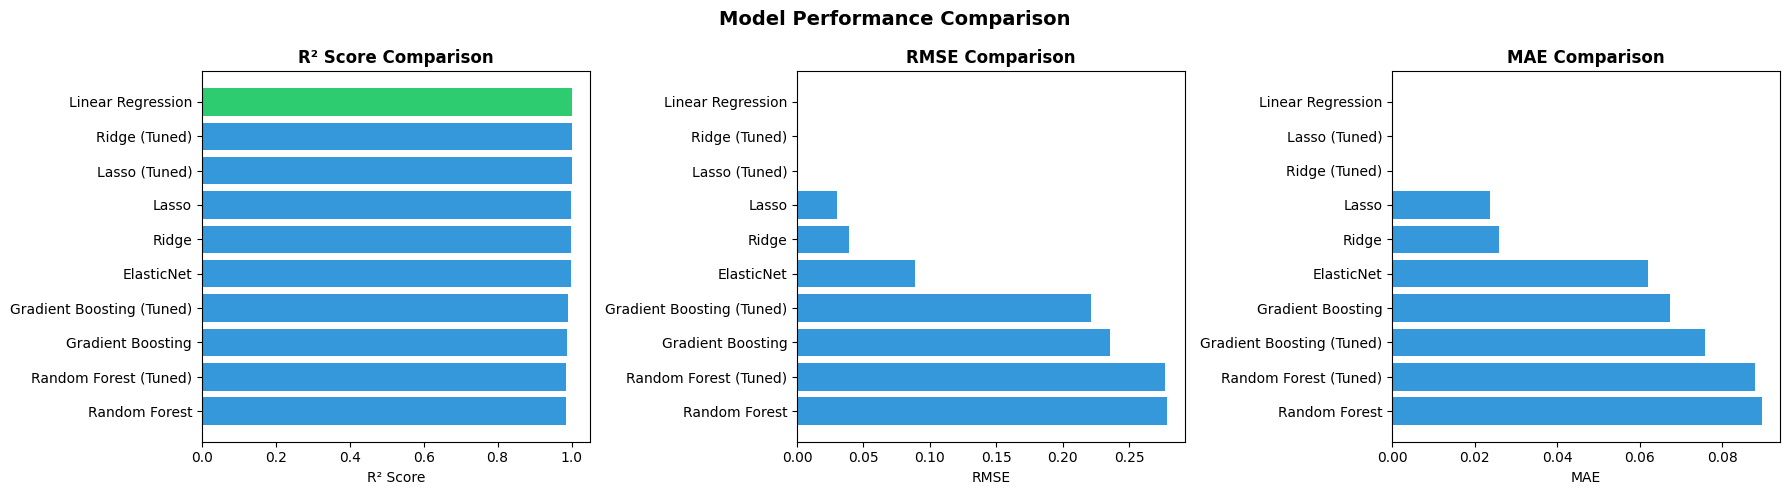

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, ['R² Score', 'RMSE', 'MAE']):
    sorted_df = summary.sort_values(metric, ascending=(metric != 'R² Score'))
    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(sorted_df))]
    ax.barh(sorted_df['Model'], sorted_df[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_xlabel(metric)
    ax.invert_yaxis()
plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## **Step 24:** Metrics Comparison – Linear, Ridge, Lasso (Train / Val / Test)

Grouped bar chart comparing R², RMSE, and MAE across datasets for the three linear models.

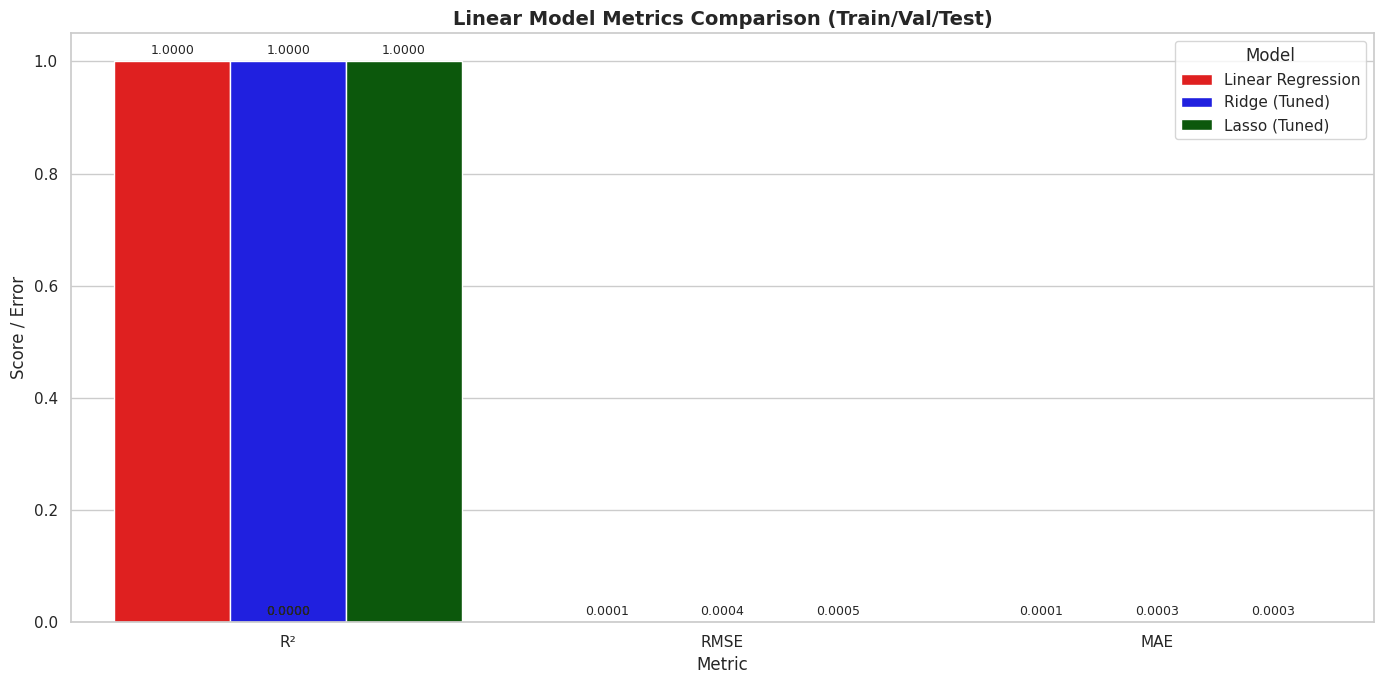

In [44]:
linear_models = split_df[split_df['Model'].isin(['Linear Regression', 'Ridge (Tuned)', 'Lasso (Tuned)'])]
results_melted = linear_models.melt(id_vars=['Model', 'Split'],
                                     value_vars=['R²', 'RMSE', 'MAE'],
                                     var_name='Metric', value_name='Value')

colors_map = {'Linear Regression': 'red', 'Ridge (Tuned)': 'blue', 'Lasso (Tuned)': 'darkgreen'}
sns.set(style='whitegrid')
plt.figure(figsize=(14, 7))
sns.barplot(data=results_melted, x='Metric', y='Value', hue='Model',
            palette=colors_map, ci=None)
ax = plt.gca()
for p in ax.patches:
    h = p.get_height()
    ax.annotate(f'{h:.4f}', (p.get_x() + p.get_width() / 2., h),
                ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points')
plt.title('Linear Model Metrics Comparison (Train/Val/Test)', fontsize=14, weight='bold')
plt.ylabel('Score / Error')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## **Step 25:** Residual Plots

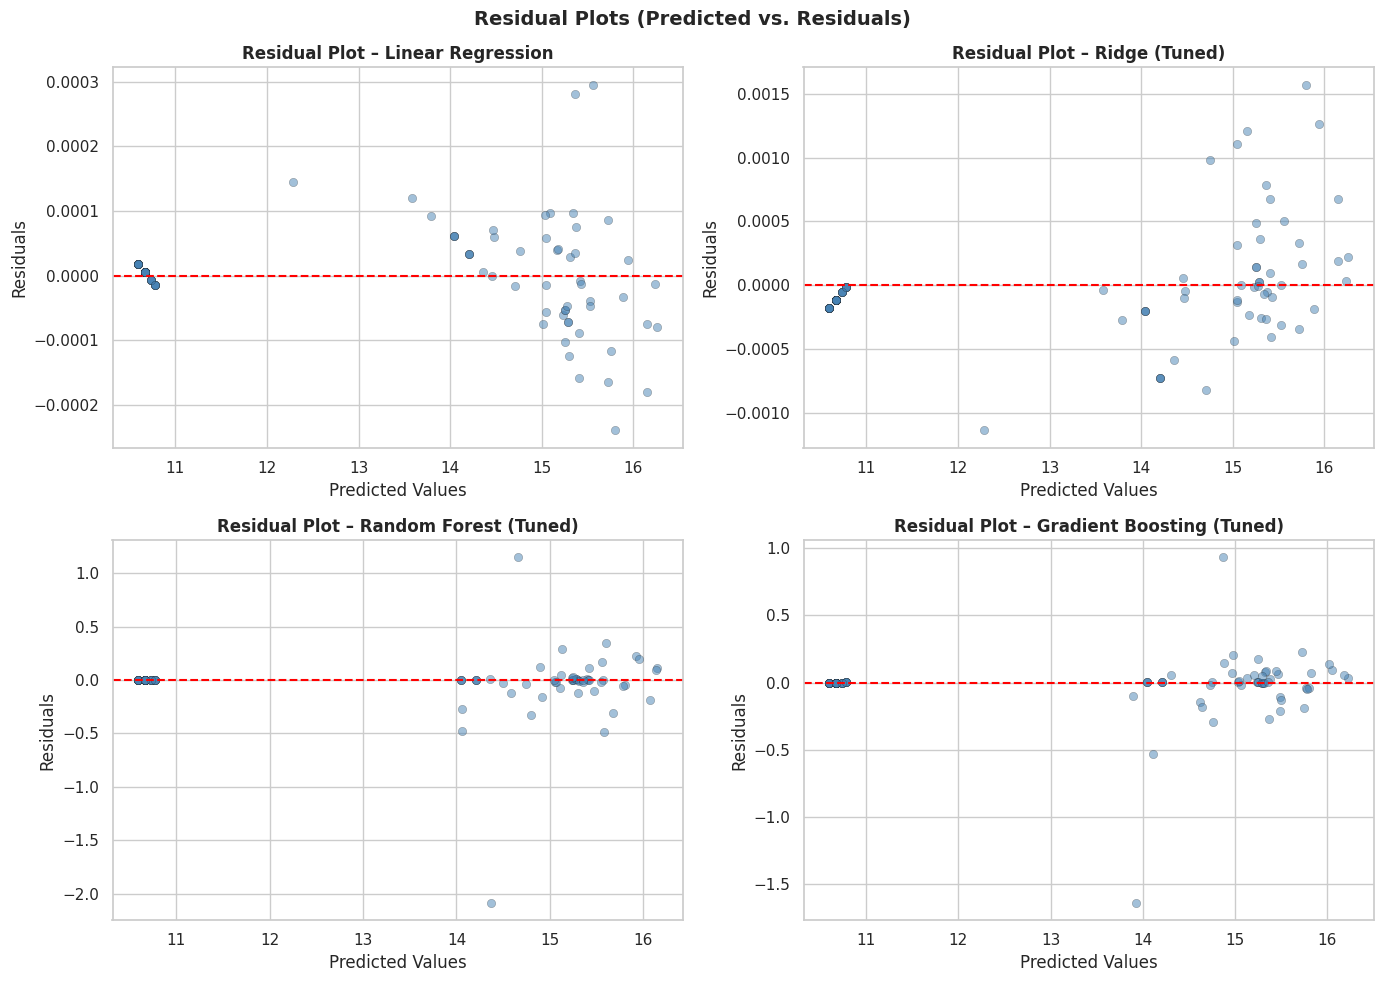

In [45]:
models_to_plot = ['Linear Regression', 'Ridge (Tuned)', 'Random Forest (Tuned)', 'Gradient Boosting (Tuned)']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, name in zip(axes, models_to_plot):
    y_pred    = results[name]['predictions']
    residuals = y_test - y_pred
    ax.scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidths=0.3, color='steelblue')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
    ax.set_title(f'Residual Plot – {name}', fontweight='bold')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')

plt.suptitle('Residual Plots (Predicted vs. Residuals)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 26: Actual vs. Predicted – Best Model

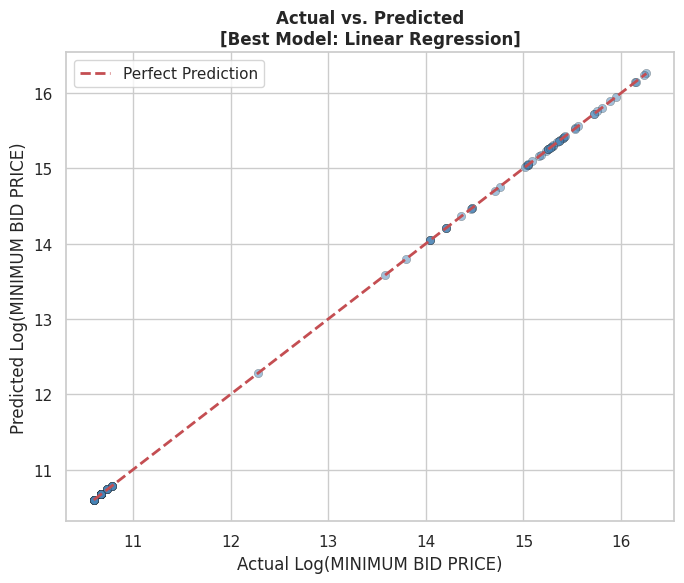

Best model: Linear Regression
  R²   = 1.0000
  RMSE = 0.0001
  MAE  = 0.0000


In [46]:
best_model_name = summary.iloc[0]['Model']
best_preds      = results[best_model_name]['predictions']

plt.figure(figsize=(7, 6))
plt.scatter(y_test, best_preds, alpha=0.5, color='steelblue', edgecolors='k', linewidths=0.3)
lims = [min(y_test.min(), best_preds.min()), max(y_test.max(), best_preds.max())]
plt.plot(lims, lims, 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Log(MINIMUM BID PRICE)')
plt.ylabel('Predicted Log(MINIMUM BID PRICE)')
plt.title(f'Actual vs. Predicted\n[Best Model: {best_model_name}]', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Best model: {best_model_name}')
print(f'  R²   = {summary.iloc[0]["R² Score"]:.4f}')
print(f'  RMSE = {summary.iloc[0]["RMSE"]:.4f}')
print(f'  MAE  = {summary.iloc[0]["MAE"]:.4f}')

## **Step 27:** Actual vs. Predicted – Linear, Lasso, Ridge Across Splits

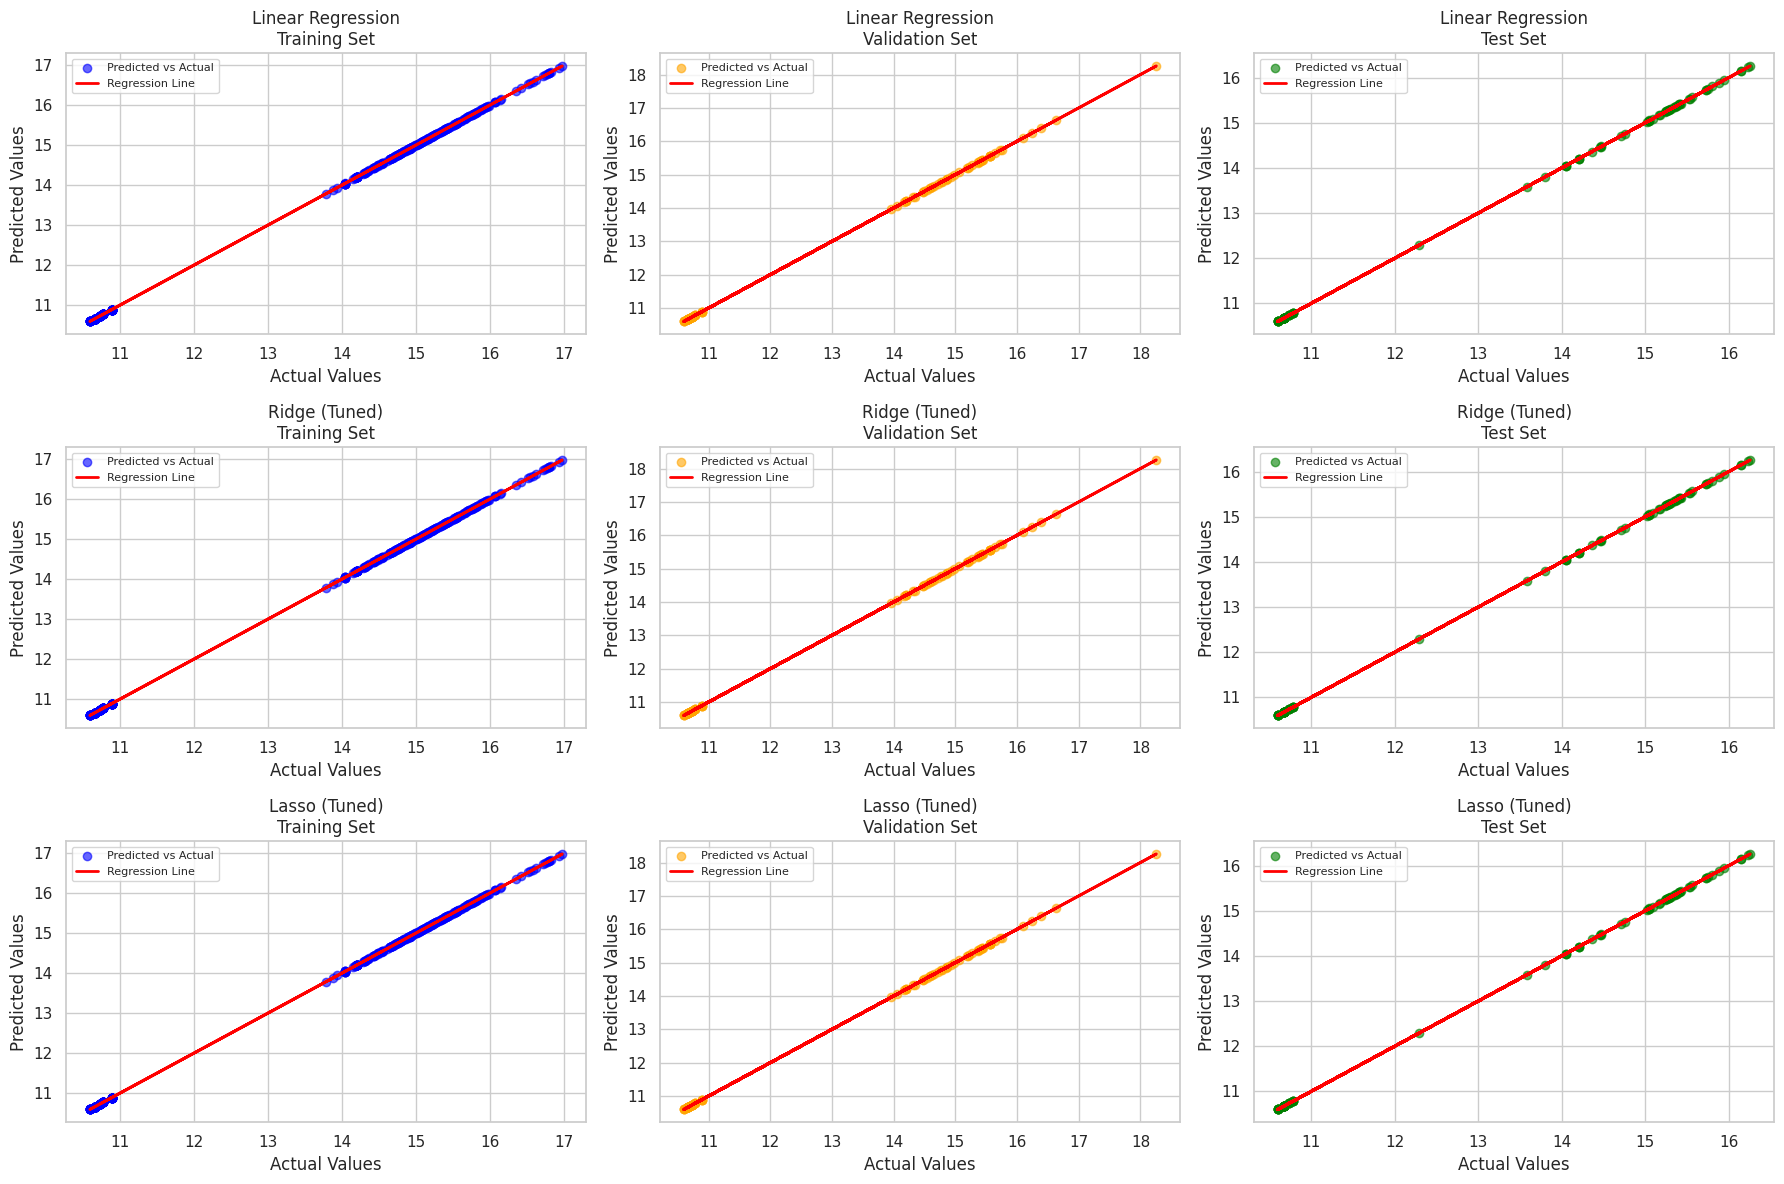

In [47]:
X_splits_map = {
    'Linear Regression': (X_train_scaled, X_val_scaled, X_test_scaled),
    'Ridge (Tuned)'    : (X_train_scaled, X_val_scaled, X_test_scaled),
    'Lasso (Tuned)'    : (X_train_scaled, X_val_scaled, X_test_scaled),
}

fig, axes_grid = plt.subplots(3, 3, figsize=(18, 12))
split_colors = ['blue', 'orange', 'green']

for row, (model_name, (X_tr, X_va, X_te)) in enumerate(X_splits_map.items()):
    model_obj = results[model_name]['fitted_model']
    for col, (split_name, X_sp, y_sp) in enumerate([
        ('Training',   X_tr, y_train),
        ('Validation', X_va, y_val),
        ('Test',       X_te, y_test)
    ]):
        ax    = axes_grid[row][col]
        y_hat = model_obj.predict(X_sp)
        ax.scatter(y_sp, y_hat, color=split_colors[col], alpha=0.6, label='Predicted vs Actual')
        m, b = np.polyfit(y_sp, y_hat, 1)
        ax.plot(y_sp, m * y_sp + b, color='red', linewidth=2, label='Regression Line')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{model_name}\n{split_name} Set')
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## **Step 28:** OLS Summary After Training

In [48]:
X_train_ols = sm.add_constant(X_train_scaled)
ols_model_after = sm.OLS(y_train, X_train_ols).fit()
print(ols_model_after.summary())

                            OLS Regression Results                            
Dep. Variable:      MINIMUM BID PRICE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.186e+10
Date:                Wed, 25 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:29:40   Log-Likelihood:                 3102.0
No. Observations:                 415   AIC:                            -6184.
Df Residuals:                     405   BIC:                            -6144.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2715   6.82e-06   1.95e+06      0.0

# **FEATURE IMPORTANCE ANALYSIS**

## **Step 29:** Tree-Based Feature Importance

Random Forest and Gradient Boosting expose `.feature_importances_`, which measures the average reduction in impurity each feature contributes across all trees.

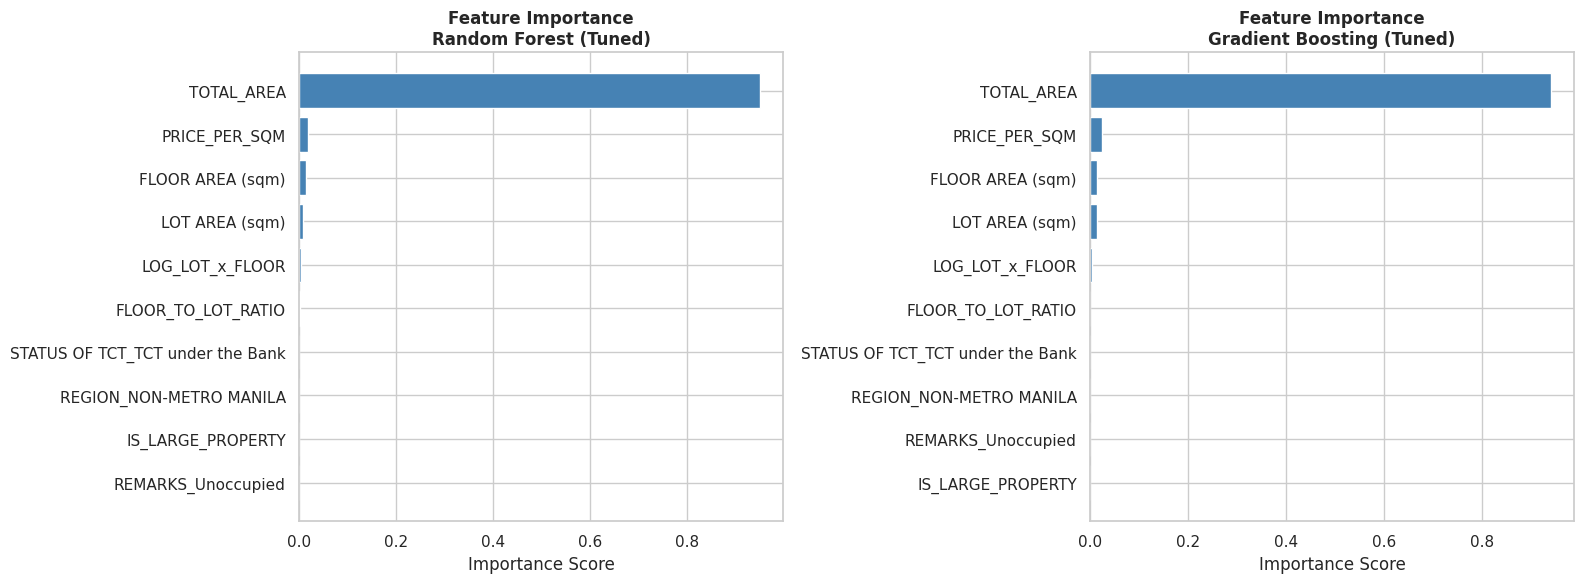

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, key in zip(axes, ['Random Forest (Tuned)', 'Gradient Boosting (Tuned)']):
    model_obj   = results[key]['fitted_model']
    importances = pd.Series(model_obj.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=True).tail(15)
    ax.barh(importances.index, importances.values, color='steelblue')
    ax.set_title(f'Feature Importance\n{key}', fontweight='bold')
    ax.set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

## **Step 30:** Lasso Coefficient Analysis

Lasso's L1 penalty drives unimportant feature coefficients to exactly zero, performing automatic feature selection. Green bars indicate positive influence on the bid price; red bars indicate negative.

Features retained by Lasso : 6 / 10
Features zeroed out        : 4


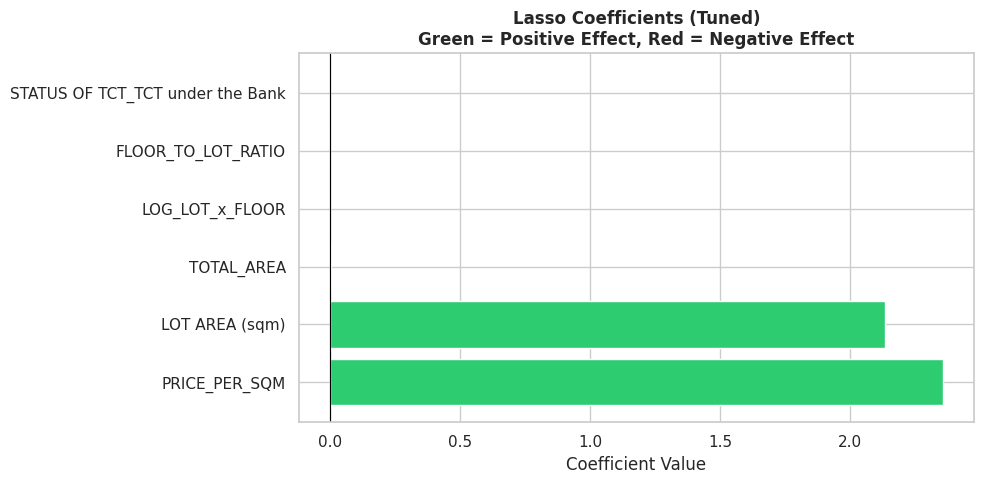

In [50]:
lasso_coef = pd.Series(best_lasso.coef_, index=X.columns).sort_values(key=abs, ascending=False)
nonzero = lasso_coef[lasso_coef != 0]
zeroed  = lasso_coef[lasso_coef == 0]

print(f'Features retained by Lasso : {len(nonzero)} / {len(lasso_coef)}')
print(f'Features zeroed out        : {len(zeroed)}')

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in nonzero.values]
plt.figure(figsize=(10, 5))
plt.barh(nonzero.index, nonzero.values, color=colors)
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Lasso Coefficients (Tuned)\nGreen = Positive Effect, Red = Negative Effect', fontweight='bold')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# **APPLYING PCA (Dimensionality Reduction)**

## **Step 31:** PCA – Explained Variance

PCA identifies the number of components needed to retain 95% of the total variance, reducing dimensionality while preserving most information.

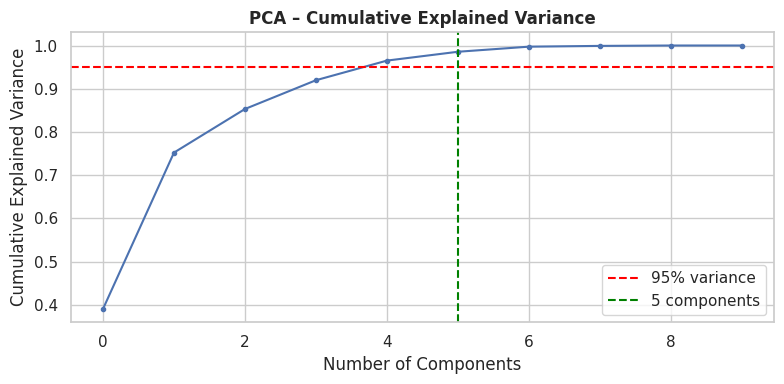

Components needed to explain 95% variance: 5


In [51]:
pca_full = PCA()
pca_full.fit(X_train_scaled)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_95   = np.argmax(cumvar >= 0.95) + 1

plt.figure(figsize=(8, 4))
plt.plot(cumvar, marker='o', markersize=3)
plt.axhline(0.95, color='red',   linestyle='--', label='95% variance')
plt.axvline(n_95, color='green', linestyle='--', label=f'{n_95} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA – Cumulative Explained Variance', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Components needed to explain 95% variance: {n_95}')

## **Step 32:** Apply PCA and Compare vs. Full Features

PCA-based model results:
  Linear + PCA                 R²=0.9534  RMSE=0.4831
  Ridge + PCA                  R²=0.9534  RMSE=0.4831
  Random Forest + PCA          R²=0.9771  RMSE=0.3384


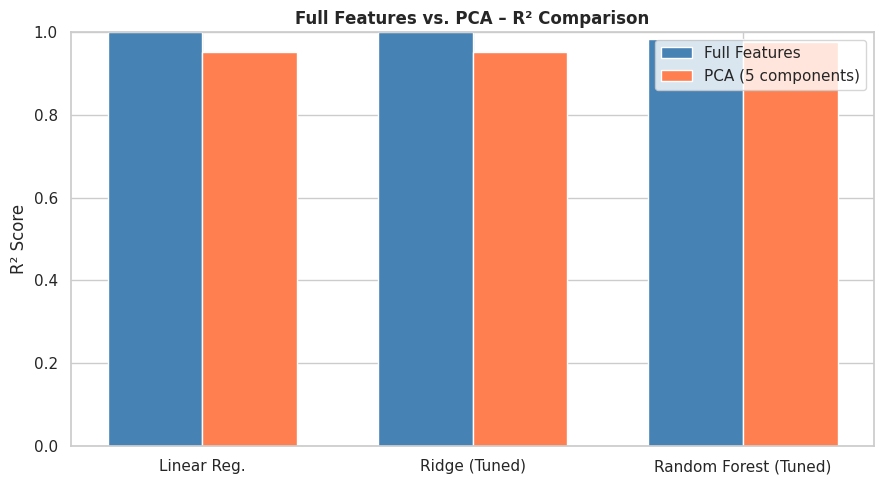


Key insight: Full-feature tree models typically outperform PCA versions.
PCA is most useful for linear models with high multicollinearity.


In [52]:
pca = PCA(n_components=n_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

pca_results = {}
pca_results['Linear + PCA'] = evaluate_model(
    'Linear + PCA', LinearRegression(), X_train_pca, y_train, X_test_pca, y_test)
pca_results['Ridge + PCA'] = evaluate_model(
    'Ridge + PCA', Ridge(alpha=ridge_gs.best_params_['alpha']), X_train_pca, y_train, X_test_pca, y_test)
pca_results['Random Forest + PCA'] = evaluate_model(
    'Random Forest + PCA', RandomForestRegressor(**rf_gs.best_params_, random_state=42, n_jobs=-1),
    X_train_pca, y_train, X_test_pca, y_test)

print('PCA-based model results:')
for k, v in pca_results.items():
    print(f'  {k:28s} R²={v["R² Score"]:.4f}  RMSE={v["RMSE"]:.4f}')

# Comparison chart
comp_df = pd.DataFrame({
    'Model': ['Linear Reg.', 'Ridge (Tuned)', 'Random Forest (Tuned)'],
    'Full Features R²': [
        results['Linear Regression']['R² Score'],
        results['Ridge (Tuned)']['R² Score'],
        results['Random Forest (Tuned)']['R² Score']
    ],
    'PCA R²': [
        pca_results['Linear + PCA']['R² Score'],
        pca_results['Ridge + PCA']['R² Score'],
        pca_results['Random Forest + PCA']['R² Score']
    ]
})

x = np.arange(len(comp_df))
width = 0.35
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - width/2, comp_df['Full Features R²'], width, label='Full Features', color='steelblue')
ax.bar(x + width/2, comp_df['PCA R²'],           width, label=f'PCA ({n_95} components)', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(comp_df['Model'])
ax.set_ylabel('R² Score')
ax.set_title('Full Features vs. PCA – R² Comparison', fontweight='bold')
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

print('\nKey insight: Full-feature tree models typically outperform PCA versions.')
print('PCA is most useful for linear models with high multicollinearity.')

# **SHAP VALUES FOR MODEL INTERPRETABILITY**

## **Step 33:** SHAP Analysis

SHAP (SHapley Additive exPlanations) explains individual predictions by attributing a contribution value to each feature. It answers: **which features push the prediction higher or lower, and by how much?**

- **Summary (bar) plot**: Global feature importance ranking.
- **Beeswarm plot**: Direction and magnitude of each feature's effect.
- **Force plot**: Per-prediction explanation for a single data point.

In [53]:
try:
    import shap
    shap_available = True
    print(f'SHAP version: {shap.__version__}')
except ImportError:
    shap_available = False
    print('SHAP not installed. Run: !pip install shap')


SHAP version: 0.50.0


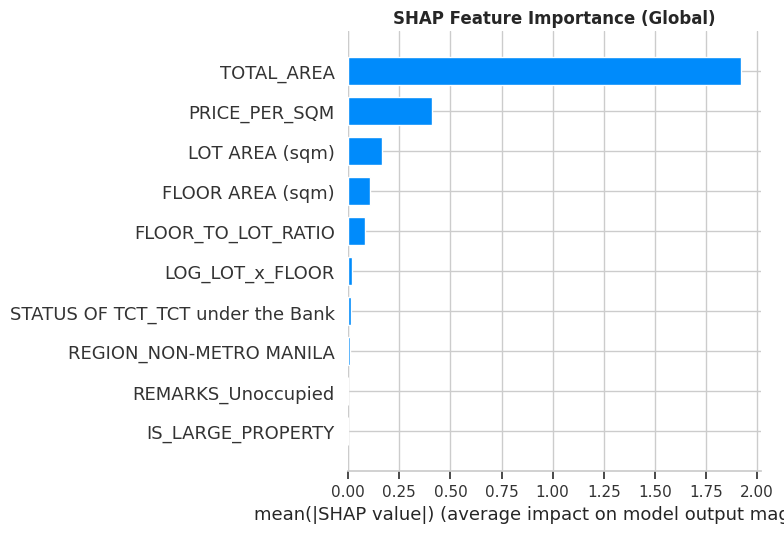

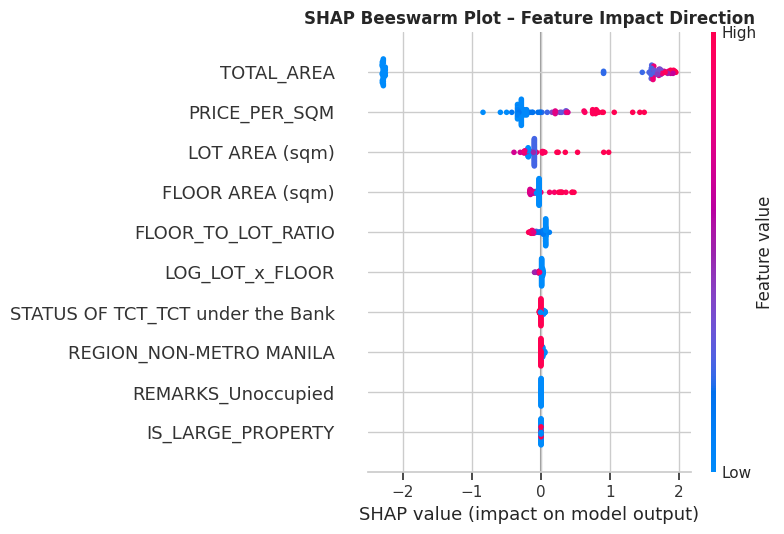

In [54]:
if shap_available:
    shap_model  = results['Gradient Boosting (Tuned)']['fitted_model']
    explainer   = shap.TreeExplainer(shap_model)
    shap_values = explainer.shap_values(X_test)

    # Global importance bar plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(),
                      plot_type='bar', show=False)
    plt.title('SHAP Feature Importance (Global)', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Beeswarm plot
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=X.columns.tolist(), show=False)
    plt.title('SHAP Beeswarm Plot – Feature Impact Direction', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Force plot – single prediction
    shap.initjs()
    display(shap.force_plot(
        explainer.expected_value,
        shap_values[0],
        X_test.iloc[0],
        feature_names=X.columns.tolist()
    ))
else:
    print('Install SHAP to run this section: !pip install shap')

# **MODEL DEPLOYMENT – Minimum Bid Price Predictor**

## Step 35: Interactive Prediction

Run the cell below and type your property details into the input boxes.

**Valid inputs:**
| Field | Accepted Values |
|---|---|
| Lot Area | Any positive number (e.g. `150`) |
| Floor Area | Any positive number or `0` if unknown |
| Region | `METRO MANILA` or `NON-METRO MANILA` |
| Remarks | `Unoccupied` or `Occupied` |
| TCT Status | `TCT under the Bank` or `For Title Consolidation` |

In [57]:
import numpy as np, pandas as pd

# ── Collect user inputs ──────────────────────────────────────────
LOT_AREA   = float(input('Enter Lot Area (sqm)                                              : '))
FLOOR_AREA = float(input('Enter Floor Area (sqm)                                            : '))
REGION     =       input('Enter Region           [ METRO MANILA / NON-METRO MANILA ]        : ').strip().upper()
REMARKS    =       input('Enter Remarks          [ Unoccupied / Occupied ]                  : ').strip().title()
TCT_STATUS =       input('Enter TCT Status       [ TCT under the Bank / For Title Consolidation ]: ').strip().title()

# Normalise TCT input
if 'bank' in TCT_STATUS.lower():
    TCT_STATUS = 'TCT under the Bank'
else:
    TCT_STATUS = ''   # 'For Title Consolidation' is the baseline (dropped)

# ── Build feature row ────────────────────────────────────────────
log_lot, log_floor = np.log1p(LOT_AREA), np.log1p(FLOOR_AREA)
row = {col: 0 for col in X.columns}
row.update({
    'LOT AREA (sqm)'    : log_lot,
    'FLOOR AREA (sqm)'  : log_floor,
    'PRICE_PER_SQM'     : np.log1p(0 / (LOT_AREA + 1)),
    'TOTAL_AREA'         : log_lot + log_floor,
    'FLOOR_TO_LOT_RATIO' : np.log1p(FLOOR_AREA / (LOT_AREA + 1)),
    'LOG_LOT_x_FLOOR'    : log_lot * log_floor,
    'IS_LARGE_PROPERTY'  : int(log_lot >= df_feat['LOT AREA (sqm)'].quantile(0.75)),
})
if f'REGION_{REGION}' in row:
    row[f'REGION_{REGION}'] = 1
if REMARKS == 'Unoccupied' and 'REMARKS_Unoccupied' in row:
    row['REMARKS_Unoccupied'] = 1
if TCT_STATUS and f'STATUS OF TCT_{TCT_STATUS}' in row:
    row[f'STATUS OF TCT_{TCT_STATUS}'] = 1

# ── Predict ──────────────────────────────────────────────────────
X_in  = pd.DataFrame([row])[X.columns].astype(float)
price = np.expm1(results['Gradient Boosting (Tuned)']['fitted_model'].predict(X_in)[0])

# ── Output ───────────────────────────────────────────────────────
print()
print(f'  Lot Area   : {LOT_AREA:,.1f} sqm')
print(f'  Floor Area : {FLOOR_AREA:,.1f} sqm')
print(f'  Region     : {REGION}')
print(f'  Remarks    : {REMARKS}')
print(f'  TCT Status : {TCT_STATUS or "For Title Consolidation (baseline)"}')
print(f'  {"─" * 46}')
print(f'  Estimated Minimum Bid Price: ₱ {price:,.2f}')

Enter Lot Area (sqm)                                              : 150
Enter Floor Area (sqm)                                            : 80
Enter Region           [ METRO MANILA / NON-METRO MANILA ]        : metro manila
Enter Remarks          [ Unoccupied / Occupied ]                  : occupied
Enter TCT Status       [ TCT under the Bank / For Title Consolidation ]: bank

  Lot Area   : 150.0 sqm
  Floor Area : 80.0 sqm
  Region     : METRO MANILA
  Remarks    : Occupied
  TCT Status : TCT under the Bank
  ──────────────────────────────────────────────
  Estimated Minimum Bid Price: ₱ 1,052,851.70
